## Simulating Model

# DGP
$ y_{it} = \alpha_i + \delta_t + \beta \times Treatment_{it} + \gamma \times Post_{t} \times Treatment_{it}+ \epsilon_{it} $

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from linearmodels import PanelOLS

np.random.seed(123)

In [211]:
T = 2
N = 5000

event_period = 2

# generate N random alphas
alpha = np.random.randn(N) # from a standard normal
alphas = np.tile(alpha, T)

# generate T random deltas
delta = np.random.randn(T)

# define a beta
beta = 0.2
gamma = 0.2

# create treatment vector
half = int(N/2)
treatment_1 = np.ones(half)
treatment_0 = np.zeros(half)
treatment = np.append(treatment_0, treatment_1)
np.random.shuffle(treatment)

treatments = np.tile(treatment, T)

# create individual id's
ids = np.arange(1,N+1)
ids = np.tile(ids, T)

In [212]:
# create a dataframe
df = pd.DataFrame({'id':ids,'alpha':alphas,'treatment':treatments})
period = [[x] * N for x in range(1,T+1)]
df['period'] = np.array(period).reshape(N*T)
df['delta'] = df['period'].apply(lambda row: delta[row-1])
df['post'] = df['period'].apply(lambda row: 1 if row >= event_period else 0)

In [227]:
# generate epsilon
df['epsilon'] = 0 * df['alpha'] + 0 * df['treatment'] + np.random.randn(N *T)
# calculate y : !!! I scale down the delta for a nicer graph
df['y'] = df['alpha'] + df['delta'] + beta * df['treatment'] + gamma * df['treatment'] * df['post'] + df['epsilon']
df.head() 

,,alpha,treatment,delta,post,epsilon,y
id,period,,,,,,
1,1,-1.085631,0.0,0.318764,0,2.526856,1.759989
2,1,0.997345,0.0,0.318764,0,0.674023,1.990132
3,1,0.282978,0.0,0.318764,0,-0.494819,0.106923
4,1,-1.506295,1.0,0.318764,0,-0.081041,-1.068572
5,1,-0.578600,1.0,0.318764,0,0.633005,0.573168


In [214]:
tab = df.groupby(['treatment','period'])['y'].mean()
tab

treatment  period
0.0        1         0.344916
           2         1.534403
1.0        1         0.579986
           2         1.931796
Name: y, dtype: float64

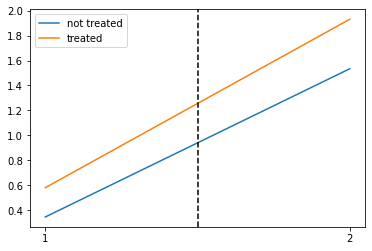

In [215]:
periods = [x for x in range(1,T+1)]

fig, ax = plt.subplots()  
plt.plot(periods,[tab[0][p] for p in periods], label = 'not treated')
plt.plot(periods,[tab[1][p] for p in periods], label = 'treated')
plt.xticks(periods)
plt.axvline(event_period - .5, linestyle='dashed', color='black')
plt.legend()
plt.show()

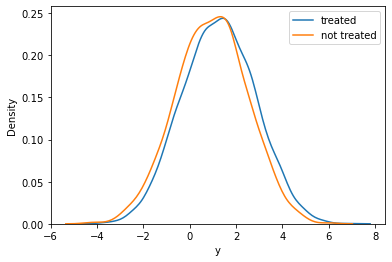

In [216]:
fig, ax = plt.subplots()
sns.kdeplot(df[df.treatment == 1]['y'], ax = ax, label = 'treated')
sns.kdeplot(df[df.treatment == 0]['y'], ax = ax, label = 'not treated')
plt.legend()
plt.show()

In [217]:
# simple ols regression

model = ols(formula='y ~ alpha + delta + treatment + treatment * post', data = df)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     3496.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        12:06:14   Log-Likelihood:                -14298.
No. Observations:               10000   AIC:                         2.861e+04
Df Residuals:                    9995   BIC:                         2.864e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1374      0.023      6.065      0.000       0.093       0.182
alpha              1.0122      0.010     98.881      0.000       0.992       1.032
delta              0.6037      0.012     50.965      0.000       0.581       0.627
treatment          0.2224      0.029      7.777      0.000       0.166       0.278
post               0.4696      0.015     31.736      0.000       0.441       0.499
treatment:post     0.1623      0.040      4.013      0.000       0.083       0.242
==============================================================================
Omnibus:                        7.921   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.488
Skew:                           0.039   Prob(JB):                       0.0237
Kurtosis:                       2.891   Cond. No.                     1.98e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.16e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [218]:
# need mulitindexed dataframe
df = df.set_index(['id','period'])

In [226]:
# Panel Ols regression
mod = PanelOLS.from_formula('y  ~ alpha + delta + treatment + treatment * post', data = df,drop_absorbed=True)
# for later: 
# + EntityEffects + TimeEffects in formula for time and individual FE
res = mod.fit()
res

Dep. Variable:,y,R-squared:,0.5832
Estimator:,PanelOLS,R-squared (Between):,0.6585
No. Observations:,10000,R-squared (Within):,0.4524
Date:,"Tue, Mar 29 2022",R-squared (Overall):,0.5832
Time:,12:13:15,Log-likelihood,-1.43e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3496.5
Entities:,5000,P-value,0.0000
Avg Obs:,2.0000,Distribution:,"F(4,9995)"
Min Obs:,2.0000,,
Max Obs:,2.0000,F-statistic (robust):,4161.9
